In [ ]:
!pip install piml

# Data Pipeline

In [2]:
from piml import Experiment
exp = Experiment()
exp.data_loader(data='CaliforniaHousing_trim2')

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [3]:
exp.data_summary()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='<link rel="stylesheet" href="//stackpath.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.…

In [4]:
exp.eda()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

In [8]:
exp.data_prepare()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

# Model Pipeline

In [ ]:
from xgboost import XGBRegressor
XGB = XGBRegressor(max_depth=5, n_estimators=500)
exp.model_train(model=XGB, name='XGB5')

In [ ]:
from sklearn.neural_network import MLPRegressor
DNN = MLPRegressor(hidden_layer_sizes=[40]*4,
                   activation="relu", random_state=0)
exp.model_train(model=DNN, name='ReLUDNN')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

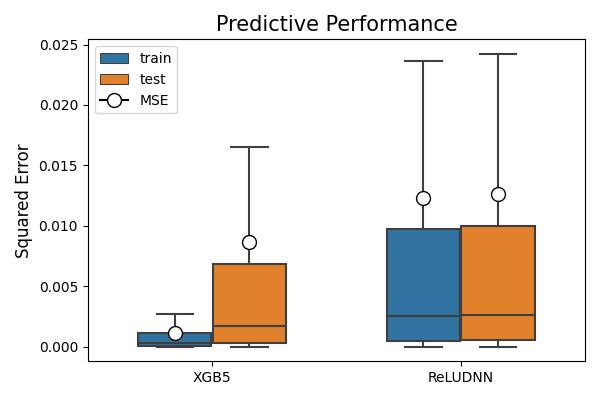

In [12]:
exp.model_compare(models=["XGB5", "ReLUDNN"],
                  show="accuracy_plot", metric="MSE",
                  figsize=(6, 4))

# Model Diagnostics

## Error Analysis

- Assess models as usual by accuracy and residuals
- Apply error slicing to identify regions with underfitting/overfitting weakness

In [13]:
exp.model_diagnose()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

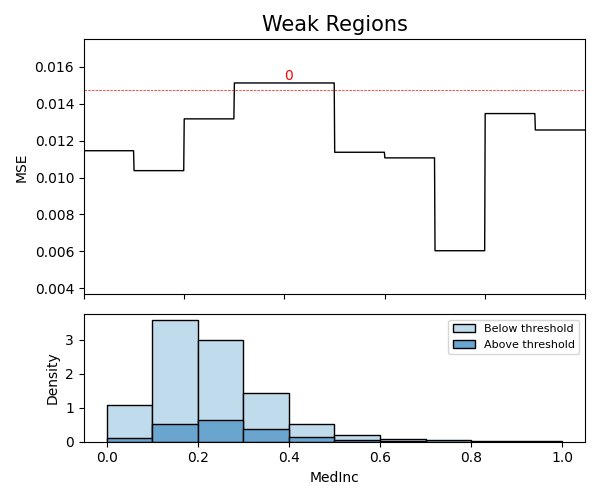

In [15]:
exp.model_diagnose(model="ReLUDNN", show="weakspot", metric="MSE",
          slice_method="histogram", slice_features=["MedInc"],
          threshold=1.2, min_samples=20, use_test=False, figsize=(6,5))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

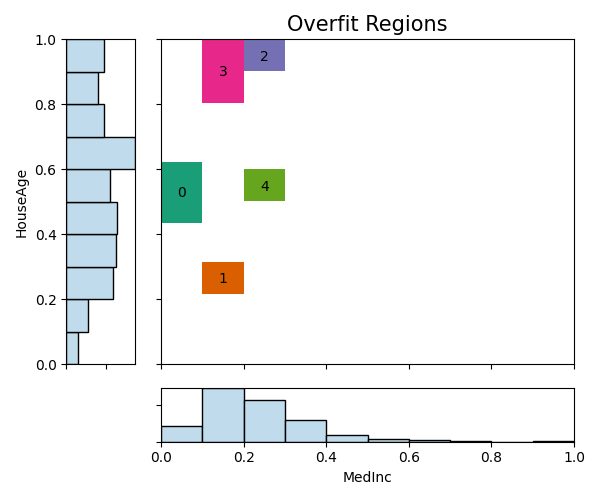

In [16]:
exp.model_diagnose(model="ReLUDNN", show="overfit", metric="MSE",
          slice_method="histogram", slice_features=["MedInc", "HouseAge"],
          threshold=1.2, min_samples=100, figsize=(6, 5))

## Resilience Test

- Run exp.model_diagnose() choose "Resilience" Tab
- Choose resilient scenarios: worst-sample, worst-cluster
- Measure distribution drift by PSI
- Verify sensitive/vulnerable variables by WeakSpot

In [17]:
exp.model_diagnose()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

## Segmented Diagnostics

- Data clustering through K-Means
- Demo use of PiML scored_test APIs for check performance heterogeneity

In [ ]:
from sklearn.cluster import KMeans
x, y, _ = exp.get_data()
train_x, train_y, _ = exp.get_data(train=True)
test_x, test_y, _ = exp.get_data(test=True)
segmodel = KMeans(n_clusters=6, random_state=0)
segmodel.fit(train_x)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

KMeans(n_clusters=6, random_state=0)

In [ ]:
# Wrap segmented scored data
TargetModel = 'ReLUDNN'
pipeline = exp.get_model(TargetModel)
feature_names = exp.get_feature_names()
feature_types = exp.get_feature_types()
prediction = pipeline.estimator.predict(x)
train_idx, test_idx = pipeline.get_train_test_idx()

trainx_seg_idx = segmodel.predict(train_x)
testx_seg_idx = segmodel.predict(test_x)

seg_scored_data = {}
for SegID in range(segmodel.n_clusters):
    scored_data = {'x': x,
             'y': y,
             'prediction': prediction,
             'train_idx': train_idx[trainx_seg_idx == SegID],
             'test_idx': test_idx[testx_seg_idx == SegID],
             'feature_names': feature_names,
             'feature_types': feature_types}
    seg_scored_data[SegID] = scored_data

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [ ]:
import pandas as pd
import ipywidgets as widgets
from piml.scored_test import test_accuracy, residual_plot, slicing_weakspot

res_all = {}
for SegID in range(segmodel.n_clusters):
  with widgets.Output():
    res_all["SegID: " + str(SegID)] = test_accuracy(**seg_scored_data[SegID])[0]
pd.concat(res_all)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

MSE      MAE       R2
                                         
SegID: 0 Train   0.0154   0.0832   0.7257
         Test    0.0155   0.0819   0.7184
         Gap     0.0001  -0.0013  -0.0073
SegID: 1 Train   0.0136   0.0813   0.8056
         Test    0.0135   0.0800   0.7980
         Gap    -0.0001  -0.0014  -0.0076
SegID: 2 Train   0.0060   0.0494   0.5615
         Test    0.0077   0.0558   0.4477
         Gap     0.0017   0.0064  -0.1137
SegID: 3 Train   0.0098   0.0665   0.8029
         Test    0.0082   0.0652   0.8305
         Gap    -0.0017  -0.0014   0.0276
SegID: 4 Train   0.0166   0.0931   0.7388
         Test    0.0178   0.0962   0.7301
         Gap     0.0012   0.0031  -0.0087
SegID: 5 Train   0.0081   0.0614   0.7935
         Test    0.0132   0.0761   0.6189
         Gap     0.0052   0.0148  -0.1746

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

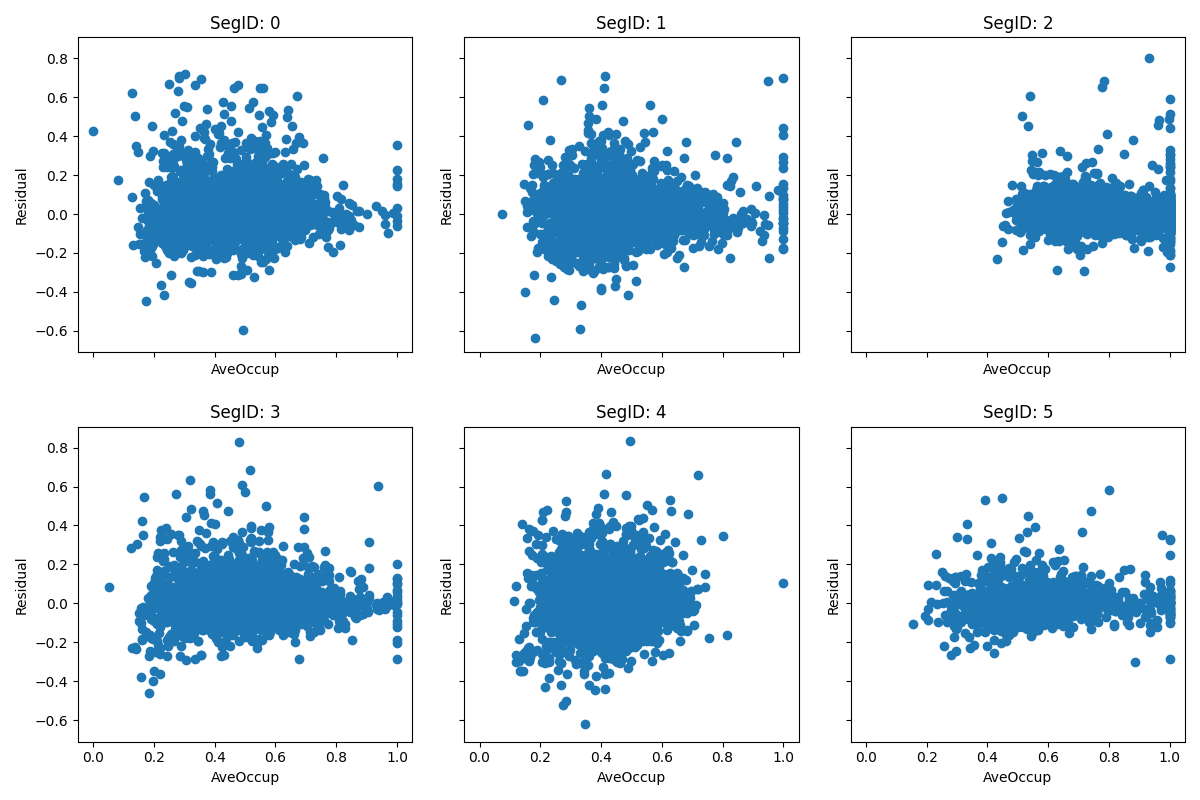

In [ ]:
from matplotlib import pylab as plt

test_mse_list = []
fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
for SegID in range(segmodel.n_clusters):
  with widgets.Output():
    res = residual_plot(show_feature='AveOccup', **seg_scored_data[SegID], figsize=(5, 4))
  axs[SegID // 3, SegID % 3].scatter(res[0]["value"]["data"]["x"], res[0]["value"]["data"]["residual"])
  axs[SegID // 3, SegID % 3].set_xlabel("AveOccup")
  axs[SegID // 3, SegID % 3].set_ylabel("Residual")
  axs[SegID // 3, SegID % 3].set_title("SegID: " + str(SegID))
fig.tight_layout(h_pad=2, w_pad=2)
fig

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

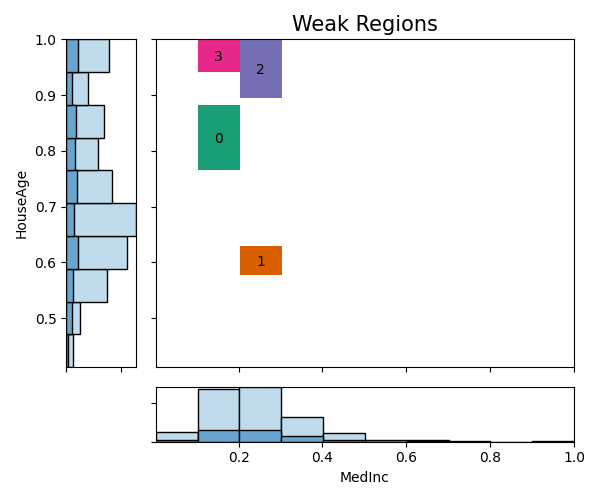

In [ ]:
SegID = 4
res = slicing_weakspot(**seg_scored_data[SegID], slice_features=["MedInc", "HouseAge"],
             threshold=1.2, slice_method="histogram",
             min_samples=20, figsize=(6, 5))